# Zadanie 7 - rzut ukośny

Przy pomocy biblioteki scikit-fuzzy zbuduj model rozmyty, który na podstawie danych wejściowych będzie szacował wartość prędkości początkowej ciała w rzucie ukośnym, aby osiągnąć dany zasięg rzutu.

Dane wejściowe:

        - zadany zasięg d

        - kąt rzutu a

         - współczynnik oporu powietrza k

        - masa ciała m

Porównaj działanie modelu z wynikami otrzymanymi ze wzoru.

a, d -> https://www.naukowiec.org/wzory/fizyka/zasieg-rzutu-ukosnego_98.html

a, d, k, m -> http://www.ftj.agh.edu.pl/~pytlik/Info/rzut_z_oporem.pdf

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import math

## Budowanie systemu dla dwóch zmiennych - a, d

In [2]:
angle = ctrl.Antecedent(np.linspace(0.0, 1.47, 150), 'angle')
distance = ctrl.Antecedent(np.arange(0, 100, 1), 'distance')

initial_velocity = ctrl.Consequent(np.arange(0, 70, 1), 'initial_velocity')

angle['bardzo maly'] = fuzz.trapmf(angle.universe, [0, 0, 0.1, 0.25])
angle['maly'] = fuzz.trimf(angle.universe, [0.1, 0.25, 0.3])
angle['sredni'] = fuzz.trapmf(angle.universe, [0.25, 0.3, 1.27, 1.32])
angle['duzy'] = fuzz.trimf(angle.universe, [1.27, 1.32, 1.37])
angle['bardzo duzy'] = fuzz.trimf(angle.universe, [1.32, 1.47, 1.47])

distance['bardzo maly'] = fuzz.trimf(distance.universe, [1, 2.5, 4+2])
distance['maly'] = fuzz.trimf(distance.universe, [4, 10, 16+3])
distance['sredni'] = fuzz.trimf(distance.universe, [16, (16+36)/2, 36+4])
distance['duzy'] = fuzz.trimf(distance.universe, [36, (36+64)/2, 64+5])
distance['bardzo duzy'] = fuzz.trimf(distance.universe, [64, (100+64)/2, 100])

initial_velocity['bardzo maly'] = fuzz.trapmf(initial_velocity.universe, [0, 0, 7, 14])
initial_velocity['maly'] = fuzz.trimf(initial_velocity.universe, [10, 20, 30])
initial_velocity['sredni'] = fuzz.trimf(initial_velocity.universe, [20, 30, 40])
initial_velocity['duzy'] = fuzz.trimf(initial_velocity.universe, [30, 40, 50])
initial_velocity['bardzo duzy'] = fuzz.trimf(initial_velocity.universe, [40, 52, 70])

initial_velocity_ctrl = ctrl.ControlSystem([ctrl.Rule(distance['bardzo maly'], initial_velocity['bardzo maly']),
                                            ctrl.Rule((angle['bardzo maly'] | angle['bardzo duzy']) & distance['maly'], initial_velocity['maly']),
                                            ctrl.Rule((angle['bardzo maly'] | angle['bardzo duzy']) & distance['sredni'], initial_velocity['sredni']),
                                            ctrl.Rule((angle['bardzo maly'] | angle['bardzo duzy']) & distance['duzy'], initial_velocity['duzy']),
                                            ctrl.Rule((angle['bardzo maly'] | angle['bardzo duzy']) & distance['bardzo duzy'], initial_velocity['bardzo duzy']),
                                            ctrl.Rule((angle['maly'] | angle['duzy']) & distance['maly'], initial_velocity['bardzo maly']),
                                            ctrl.Rule((angle['maly'] | angle['duzy']) & distance['sredni'], initial_velocity['maly']),
                                            ctrl.Rule((angle['maly'] | angle['duzy']) & distance['duzy'], initial_velocity['sredni']),
                                            ctrl.Rule((angle['maly'] | angle['duzy']) & distance['bardzo duzy'], initial_velocity['duzy']),
                                            ctrl.Rule(angle['sredni'] & distance['maly'], initial_velocity['bardzo maly']),
                                            ctrl.Rule(angle['sredni'] & distance['sredni'], initial_velocity['maly']),
                                            ctrl.Rule(angle['sredni'] & distance['duzy'], initial_velocity['maly']),
                                            ctrl.Rule(angle['sredni'] & distance['bardzo duzy'], initial_velocity['sredni'])])

initial_velocity_sim = ctrl.ControlSystemSimulation(initial_velocity_ctrl)

c:\Users\Lidia\AppData\Local\Programs\Python\Python310\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


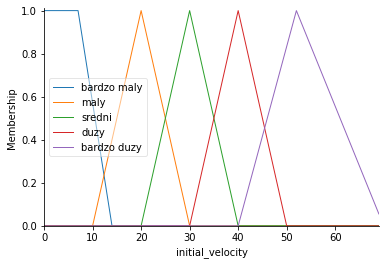

In [3]:
initial_velocity.view()

Generowanie zbioru danych do sprawdzenia modelu

In [4]:
rd = range(5, 100)
ra = np.linspace(0.1, 1.47, 100)

permutations = list(itertools.product(rd, ra))

df = pd.DataFrame(permutations, columns=['d', 'a'])

In [11]:
def first_velo(d, a):
    return math.sqrt((d*9.8)/math.sin(2*a))

df['v0'] = df.apply(lambda row: first_velo(row['d'], row['a']), axis=1)

In [12]:
mse = 0
minx = 100
maxx = -100

for index, row in df.iterrows():
    initial_velocity_sim.input['angle'] = row['a']
    initial_velocity_sim.input['distance'] = row['d']
    initial_velocity_sim.compute()
    if initial_velocity_sim.output['initial_velocity'] < minx:
        minx = initial_velocity_sim.output['initial_velocity']
    if initial_velocity_sim.output['initial_velocity'] > maxx:
        maxx = initial_velocity_sim.output['initial_velocity']
    mse = mse + np.abs(initial_velocity_sim.output['initial_velocity']-row['v0'])
    initial_velocity_sim.reset()
    
print(mse/len(df))
print('max', maxx)
print('min', minx)

3.2695191333689233
max 39.389708275494556
min 5.592592592592592


## Budowanie systemu dla czterech zmiennych - a, d, c, m

In [6]:
from scipy.optimize import fsolve

def equation(t, a, d, c, m):
    g = 9.81
    b = c/m
    return np.sin(a)/np.cos(a)*d+g/b**2*(1-np.e**(-b*t))-g*t/b

In [7]:
def second_velo(a, d, c, m, t):
    b = c/m
    return b*d/(1-np.e**(-b*t))/np.sin(a)

In [8]:
def calculate_velo(a, d, c, m):
    solution = fsolve(equation, 10, (a, d, c, m))
    return second_velo(a, d, c, m, *solution)

In [9]:
rd = range(5, 51, 2)
ra = np.linspace(0.2, 1.37, 50)
rc = np.linspace(0.1, 1, 10)
rm = range(1,51)

permutations = list(itertools.product(rd, ra, rc, rm))

df = pd.DataFrame(permutations, columns=['d', 'a', 'c', 'm'])

In [12]:
def v(a, d, c, m):
    return calculate_velo(a, d, c, m)

df['v0'] = df.apply(lambda row: v(row['a'], row['d'], row['c'], row['m']), axis=1)

Budowanie systemu

In [13]:
#inputs
distance = ctrl.Antecedent(np.arange(5, 51, 1), 'distance')
angle = ctrl.Antecedent(np.linspace(0.2, 1.37, 100), 'angle')
resistance = ctrl.Antecedent(np.linspace(0.1, 1, 30), 'resistance')
mass = ctrl.Antecedent(np.arange(0, 51, 1), 'mass')
#output
velocity = ctrl.Consequent(np.arange(0, 150, 1), 'velocity')

In [14]:
#distance and angle from the previous model
angle['bardzo maly'] = fuzz.trimf(angle.universe, [0.2, 0.2, 0.4])
angle['maly'] = fuzz.trimf(angle.universe, [0.2, 0.4, 0.6])
angle['sredni'] = fuzz.trapmf(angle.universe, [0.4, 0.6, 0.97, 1.17])
angle['duzy'] = fuzz.trimf(angle.universe, [0.97, 1.17, 1.37])
angle['bardzo duzy'] = fuzz.trimf(angle.universe, [1.17, 1.37, 1.37])

distance['bardzo maly'] = fuzz.trimf(distance.universe, [5, 5, 15])
distance['maly'] = fuzz.trimf(distance.universe, [5, 15, 25])
distance['sredni'] = fuzz.trimf(distance.universe, [15, 25, 35])
distance['duzy'] = fuzz.trimf(distance.universe, [25, 35, 45])
distance['bardzo duzy'] = fuzz.trapmf(distance.universe, [35, 45, 50, 50])

resistance['maly'] = fuzz.membership.trimf(resistance.universe,[0,0,0.5])
resistance['sredni'] = fuzz.membership.trimf(resistance.universe,[0,0.5,1])
resistance['duzy'] = fuzz.membership.trimf(resistance.universe,[0.5,1,1])

mass['maly'] = fuzz.trimf(mass.universe, [0, 0, 20])
mass['sredni'] = fuzz.trapmf(mass.universe, [0, 20, 30, 50])
mass['duzy'] = fuzz.trimf(mass.universe, [30, 50, 50])

velocity['bardzo maly'] = fuzz.trapmf(velocity.universe, [0, 0, 10, 20])
velocity['maly'] = fuzz.trimf(velocity.universe, [10, 20, 50])
velocity['sredni'] = fuzz.trimf(velocity.universe, [20, 50, 70])
velocity['duzy'] = fuzz.trimf(velocity.universe, [50, 70, 100])
velocity['bardzo duzy'] = fuzz.trapmf(velocity.universe, [70, 100, 150, 150]) 

In [15]:
model2 = ctrl.ControlSystem([ctrl.Rule(angle['bardzo maly'] & (distance['bardzo duzy'] | distance['duzy']) & mass['duzy'], velocity['bardzo duzy']),
                             ctrl.Rule(angle['maly'] & (distance['bardzo duzy'] | distance['duzy']) & mass['duzy'], velocity['sredni']),
                             ctrl.Rule((angle['sredni'] | angle['duzy'] | angle['bardzo duzy']) & mass['duzy'], velocity['maly']),
                             ctrl.Rule(angle['duzy'] & (distance['bardzo duzy'] | distance['duzy']) & mass['duzy'], velocity['bardzo maly']),
                             ctrl.Rule(angle['bardzo maly'] & distance['bardzo maly'] & (resistance['maly'] | resistance['sredni'] | resistance['duzy']) & (mass['maly'] | mass['sredni'] | mass['duzy']), velocity['sredni']),
                             ctrl.Rule(angle['maly'] & distance['bardzo maly'] & (resistance['maly'] | resistance['sredni'] | resistance['duzy']) & (mass['maly'] | mass['sredni'] | mass['duzy']), velocity['maly']),
                             ctrl.Rule((angle['sredni'] | angle['duzy'] | angle['bardzo duzy']) & mass['maly'], velocity['bardzo maly']),
                             ctrl.Rule(angle['sredni'] & distance['bardzo maly'] & mass['sredni'] & (resistance['maly'] | resistance['sredni'] | resistance['duzy']), velocity['bardzo maly']),
                             ctrl.Rule(angle['bardzo duzy'] & distance['bardzo maly'] & mass['sredni'] & (resistance['maly'] | resistance['sredni'] | resistance['duzy']), velocity['bardzo maly']),
                             ctrl.Rule(angle['bardzo maly'] & (distance['maly'] | distance['sredni']) & (resistance['maly'] | resistance['sredni'] | resistance['duzy']) & (mass['maly'] | mass['sredni'] | mass['duzy']), velocity['bardzo duzy']),
                             ctrl.Rule(angle['maly'] & distance['maly'] & mass['sredni'] & (resistance['maly'] | resistance['sredni'] | resistance['duzy']), velocity['maly']),
                             ctrl.Rule((angle['sredni'] | angle['duzy'] | angle['bardzo duzy']) & distance['maly'] & mass['sredni'] & (resistance['maly'] | resistance['sredni'] | resistance['duzy']), velocity['bardzo maly']),
                             ctrl.Rule(angle['maly'] & distance['maly'] & mass['sredni'], velocity['sredni']),
                             ctrl.Rule(angle['maly'] & (distance['sredni'] | distance['duzy']) & (resistance['maly'] | resistance['sredni'] | resistance['duzy']) & mass['sredni'], velocity['sredni']),
                             ctrl.Rule(angle['sredni'] & (distance['sredni'] | distance['duzy']) & (resistance['maly'] | resistance['sredni'] | resistance['duzy']) & mass['sredni'], velocity['maly']),
                             ctrl.Rule((angle['duzy'] | angle['bardzo duzy']) & (distance['sredni'] | distance['duzy'] | distance['bardzo duzy']) & (resistance['maly'] | resistance['sredni'] | resistance['duzy']) & (mass['sredni'] | mass['duzy']), velocity['bardzo maly']),
                             ctrl.Rule(angle['bardzo maly'] & distance['duzy'] & (resistance['maly'] | resistance['sredni'] | resistance['duzy']), velocity['bardzo duzy']),
                             ctrl.Rule(angle['bardzo maly'] & distance['bardzo duzy'], velocity['bardzo duzy']),
                             ctrl.Rule(angle['maly'] & distance['bardzo duzy'], velocity['sredni']),
                             ctrl.Rule(angle['sredni'] & distance['bardzo duzy'], velocity['maly'])
                             ])


initial_velocity_sim2 = ctrl.ControlSystemSimulation(model2)

In [16]:
blad = 0
i = 0

for index, row in df.iterrows():
    initial_velocity_sim2.input['angle'] = row['a']
    initial_velocity_sim2.input['distance'] = row['d']
    initial_velocity_sim2.input['mass'] = row['m']
    initial_velocity_sim2.input['resistance'] = row['c']
    initial_velocity_sim2.compute()

    calculated = initial_velocity_sim2.output['velocity']
    diff = np.abs(calculated-row['v0'])
    
    if row['v0']<150:
        i = i + 1
        blad = blad + diff
    
    initial_velocity_sim2.reset()

print(np.round(i/len(df)*100, 2), '%')
print(blad/i)

99.29 %
8.770724860370022
